In [1]:

import datetime as dt
import sys
import numpy as np
from numpy import cumsum, log, polyfit, sqrt, std, subtract
from numpy.random import randn
import pandas as pd
from pandas_datareader import data as web
import seaborn as sns
from pylab import rcParams 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from arch import arch_model
from numpy.linalg import LinAlgError
from scipy import stats
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot, moment
from arch import arch_model
from arch.univariate import ConstantMean, GARCH, Normal
from sklearn.model_selection import TimeSeriesSplit
import warnings

In [2]:
%matplotlib inline
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')
sns.set(style="darkgrid", color_codes=True)
rcParams['figure.figsize'] = 8,4

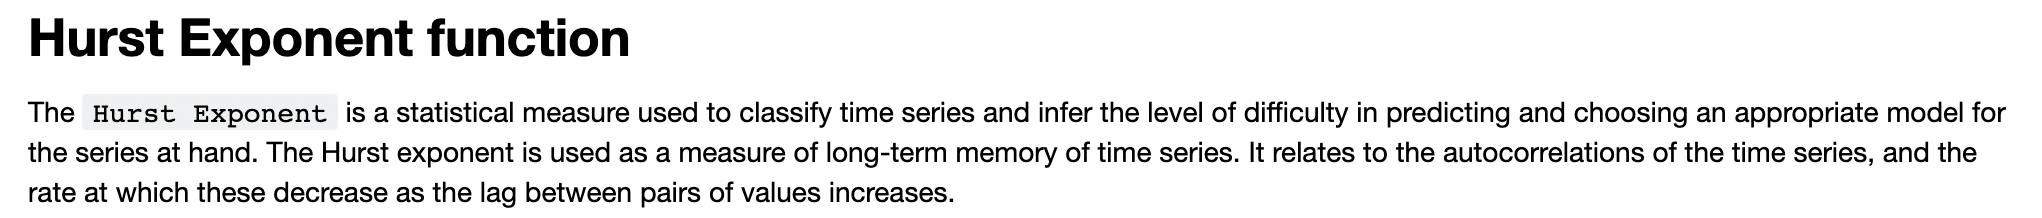

In [3]:
def hurst(ts):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 100)
    
    # Calculate the array of the variances of the lagged differences
    tau = [sqrt(std(subtract(ts[lag:], ts[:-lag]))) for lag in lags]
    
    # Use a linear fit to estimate the Hurst Exponent
    poly = polyfit(log(lags), log(tau), 1)
    
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0

In [4]:
def plot_correlogram(x, lags=None, title=None):    
    lags = min(10, int(len(x)/5)) if lags is None else lags
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    x.plot(ax=axes[0][0])
    q_p = np.max(q_stat(acf(x, nlags=lags), len(x))[1])
    stats = f'Q-Stat: {np.max(q_p):>8.2f}\nADF: {adfuller(x)[1]:>11.2f} \nHurst: {round(hurst(x.values),2)}'
    axes[0][0].text(x=.02, y=.85, s=stats, transform=axes[0][0].transAxes)
    probplot(x, plot=axes[0][1])
    mean, var, skew, kurtosis = moment(x, moment=[1, 2, 3, 4])
    s = f'Mean: {mean:>12.2f}\nSD: {np.sqrt(var):>16.2f}\nSkew: {skew:12.2f}\nKurtosis:{kurtosis:9.2f}'
    axes[0][1].text(x=.02, y=.75, s=s, transform=axes[0][1].transAxes)
    plot_acf(x=x, lags=lags, zero=False, ax=axes[1][0])
    plot_pacf(x, lags=lags, zero=False, ax=axes[1][1])
    axes[1][0].set_xlabel('Lag')
    axes[1][1].set_xlabel('Lag')
    fig.suptitle(title, fontsize=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.9)

In [5]:
start = pd.Timestamp('2020-07-24')
end = pd.Timestamp('2021-07-20')

sp_data = pd.read_csv('Props_price.csv')

sp_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        370 non-null    object 
 1   Open*       370 non-null    float64
 2   High        370 non-null    float64
 3   Low         370 non-null    float64
 4   Close**     370 non-null    float64
 5   Volume      370 non-null    float64
 6   Market Cap  370 non-null    float64
dtypes: float64(6), object(1)
memory usage: 20.4+ KB


In [6]:
sp_data.head()

,Date,Open*,High,Low,Close**,Volume,Market Cap
0,7/20/20,0.04470,0.05712,0.04227,0.04825,0.0,0.0
1,7/21/20,0.04821,0.05189,0.04634,0.04644,0.0,0.0
2,7/22/20,0.04645,0.05624,0.04023,0.04462,0.0,0.0
3,7/23/20,0.04462,0.05016,0.04119,0.04572,0.0,0.0
4,7/24/20,0.04572,0.05006,0.04321,0.04758,0.0,0.0


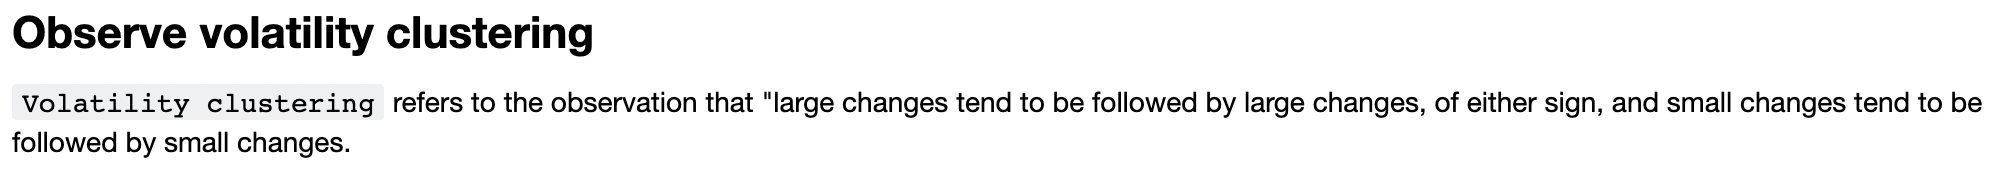

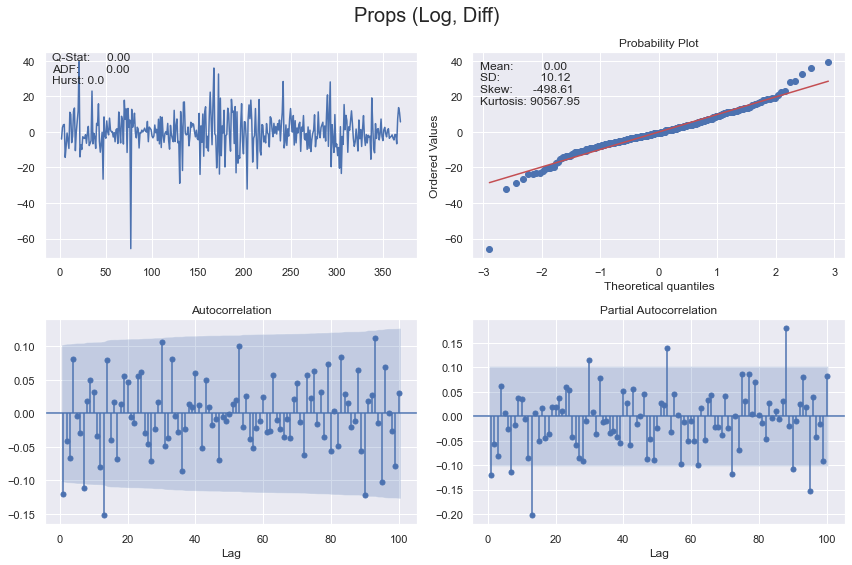

In [9]:
# Calculate daily returns as percentage price changes
sp_data['Return'] = 100 * (sp_data['Close**'].pct_change())
sp_data['Log_Return'] = np.log(sp_data['Close**']).diff().mul(100) # rescale to faciliate optimization
sp_data = sp_data.dropna()

# Plot ACF, PACF and Q-Q plot and get ADF p-value of series
plot_correlogram(sp_data['Log_Return'], lags=100, title='Props (Log, Diff)')

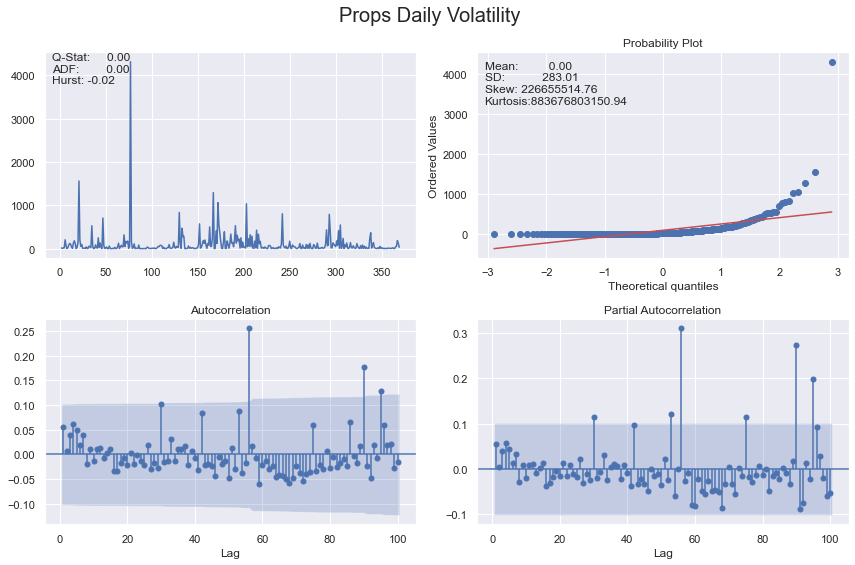

In [11]:
plot_correlogram(sp_data['Log_Return'].sub(sp_data['Log_Return'].mean()).pow(2), lags=100, title='Props Daily Volatility')

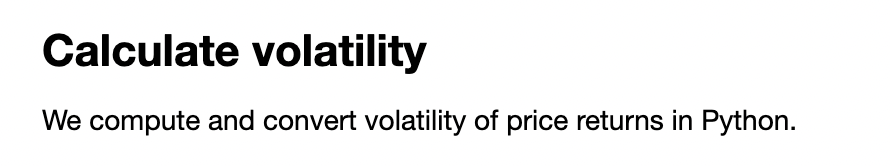

In [12]:
# Calculate daily std of returns
std_daily = sp_data['Return'].std()
print(f'Daily volatility: {round(std_daily,2)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print(f'\nMonthly volatility: {round(std_monthly,2)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily
print(f'\nAnnual volatility: {round(std_annual,2)}%')

Daily volatility: 10.11%

Monthly volatility: 46.32%

Annual volatility: 160.45%


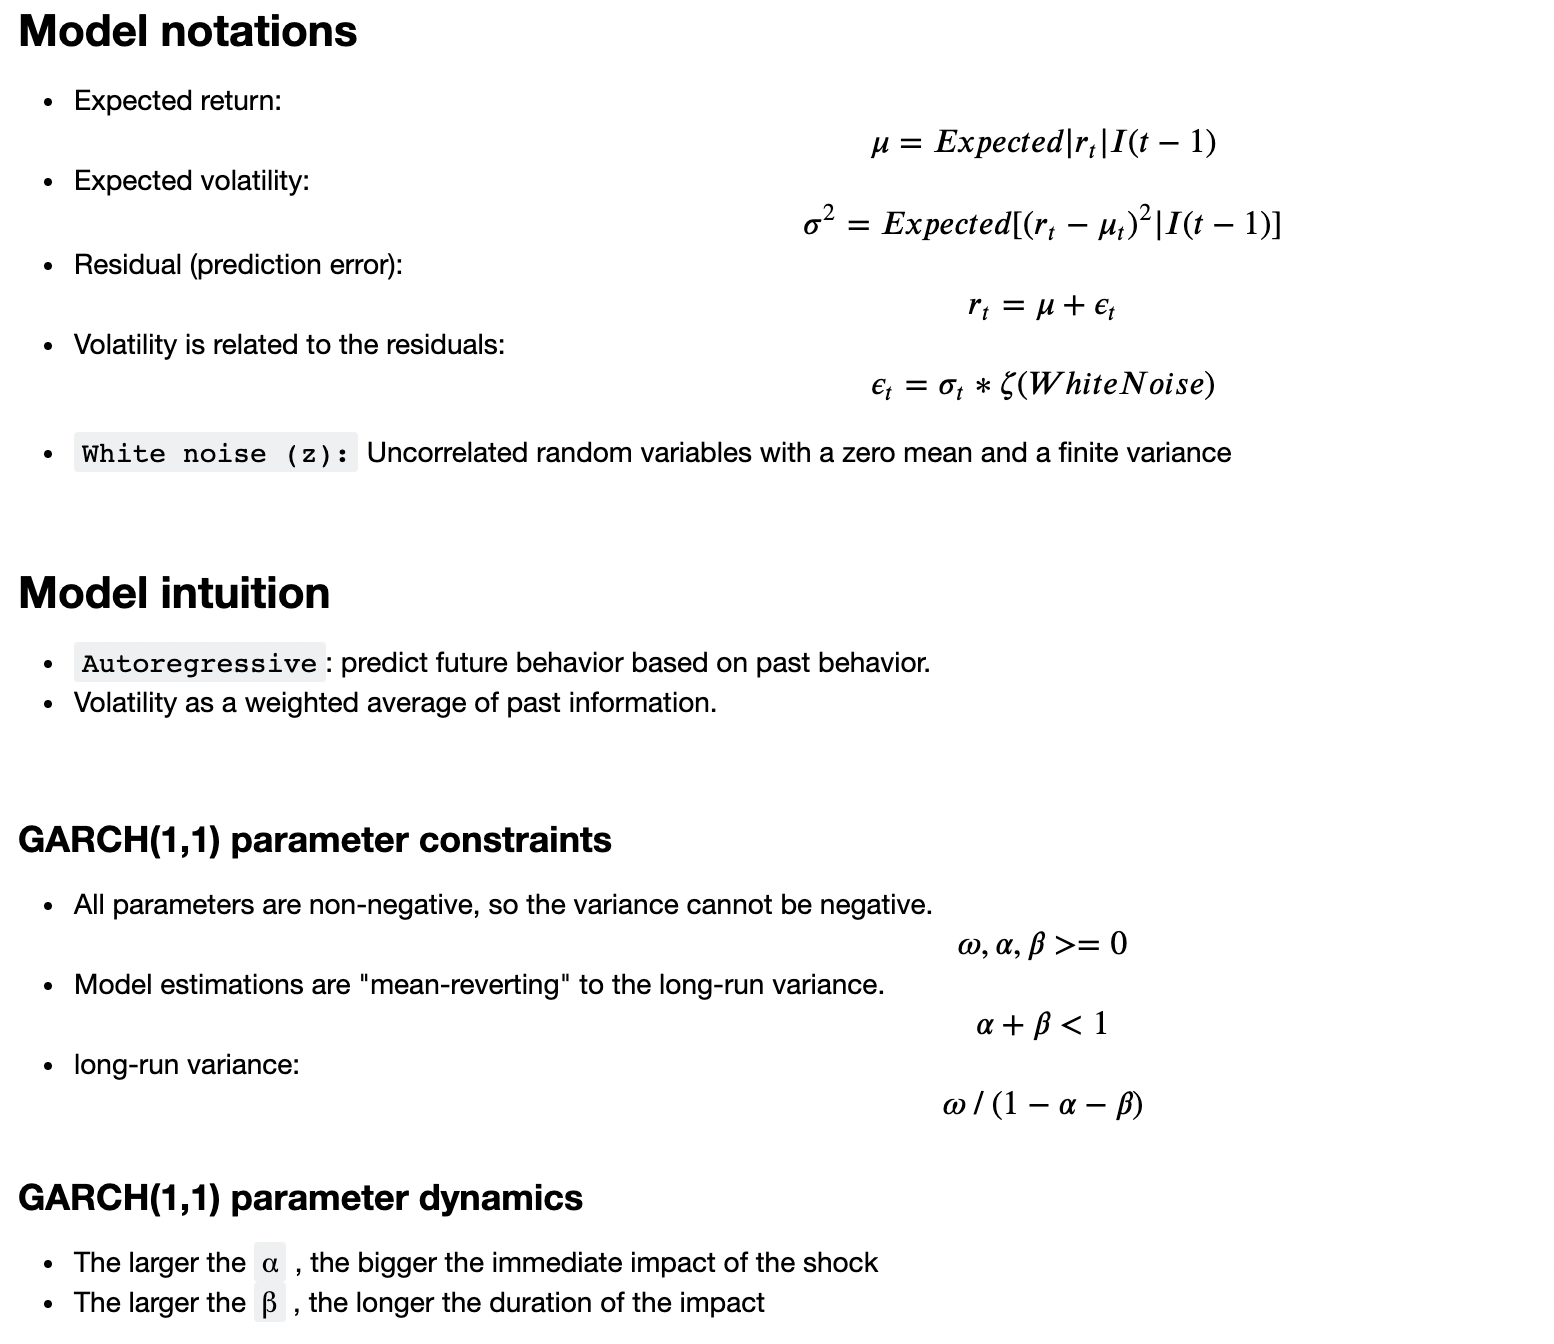

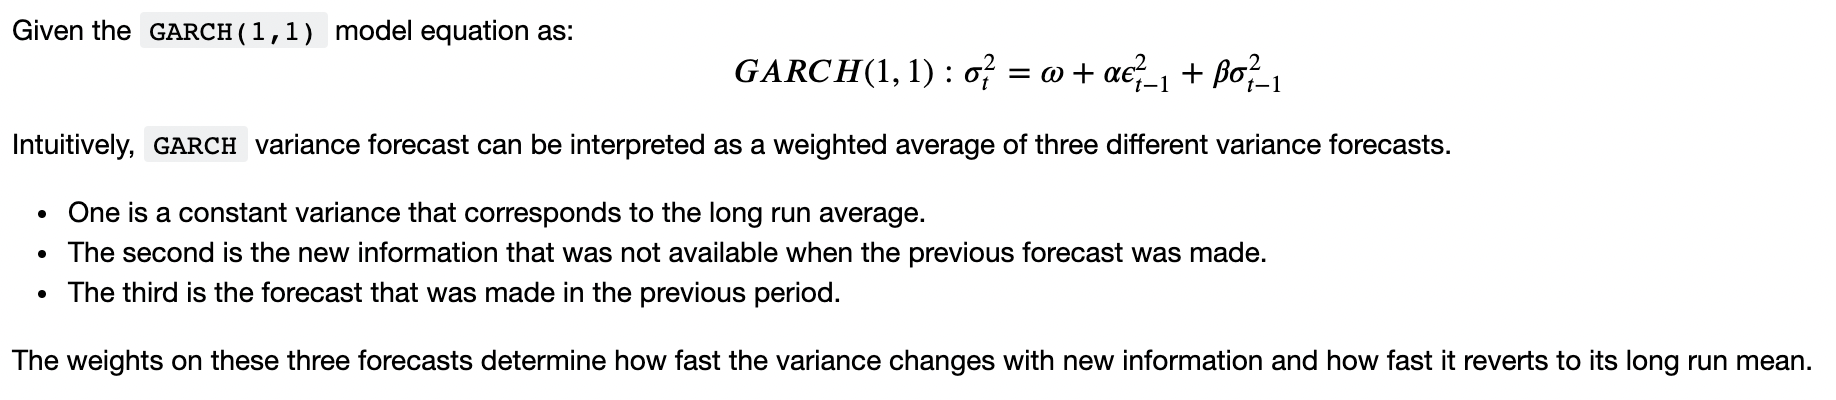

# Simulate ARCH and GARCH series

We will simulate an ARCH(1) and GARCH(1,1) time series respectively using a function simulate_GARCH(n, omega, alpha, beta = 0).

Recall the difference between an ARCH(1) and a GARCH(1,1) model is: besides an autoregressive component of α multiplying lag-1 residual squared, a GARCH model includes a moving average component of β multiplying lag-1 variance.

The function will simulate an ARCH/GARCH series based on n (number of simulations), omega, alpha, and beta (0 by default) you specify. It will return simulated residuals and variances.

In [13]:
def simulate_GARCH(n, omega, alpha, beta = 0):
    np.random.seed(4)
    # Initialize the parameters
    white_noise = np.random.normal(size = n)
    resid = np.zeros_like(white_noise)
    variance = np.zeros_like(white_noise)
    
    for t in range(1, n):
        # Simulate the variance (sigma squared)
        variance[t] = omega + alpha * resid[t-1]**2 + beta * variance[t-1]
        # Simulate the residuals
        resid[t] = np.sqrt(variance[t]) * white_noise[t]    
    
    return resid, variance

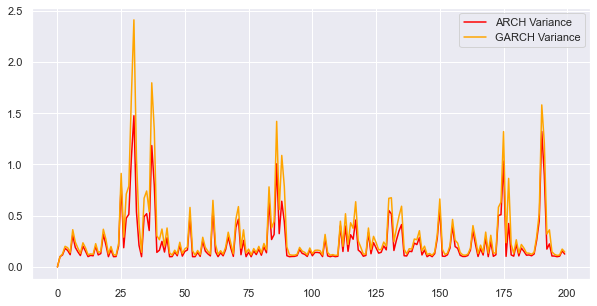

In [14]:
# Simulate a ARCH(1) series
arch_resid, arch_variance = simulate_GARCH(n= 200, 
                                           omega = 0.1, alpha = 0.7)
# Simulate a GARCH(1,1) series
garch_resid, garch_variance = simulate_GARCH(n= 200, 
                                             omega = 0.1, alpha = 0.7, 
                                             beta = 0.1)

# Plot the ARCH variance
plt.figure(figsize=(10,5))
plt.plot(arch_variance, color = 'red', label = 'ARCH Variance')

# Plot the GARCH variance
plt.plot(garch_variance, color = 'orange', label = 'GARCH Variance')
plt.legend()
plt.show()

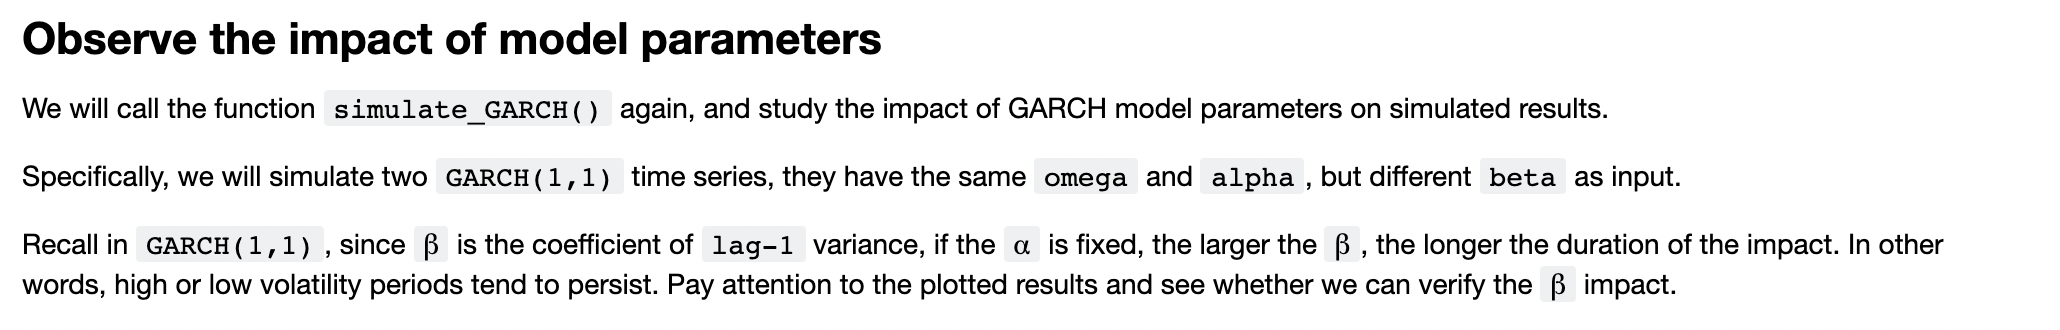

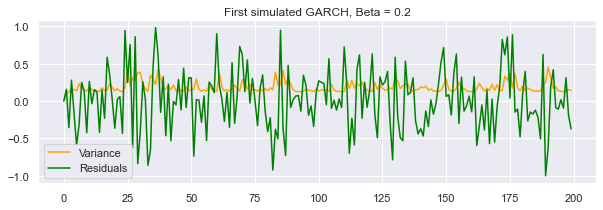

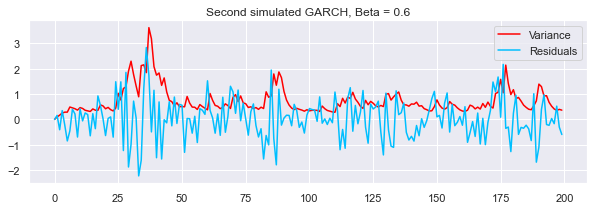

In [15]:
# First simulated GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.2)
plt.plot(sim_variance, color = 'orange', label = 'Variance')
plt.plot(sim_resid, color = 'green', label = 'Residuals')
plt.title('First simulated GARCH, Beta = 0.2')
plt.legend(loc='best')
plt.show()

# Second simulated GARCH
plt.figure(figsize=(10,3))
sim_resid, sim_variance = simulate_GARCH(n = 200,  omega = 0.1, alpha = 0.3, beta = 0.6)
plt.plot(sim_variance, color = 'red', label = 'Variance')
plt.plot(sim_resid, color = 'deepskyblue', label = 'Residuals')
plt.title('Second simulated GARCH, Beta = 0.6')
plt.legend(loc='best')
plt.show()

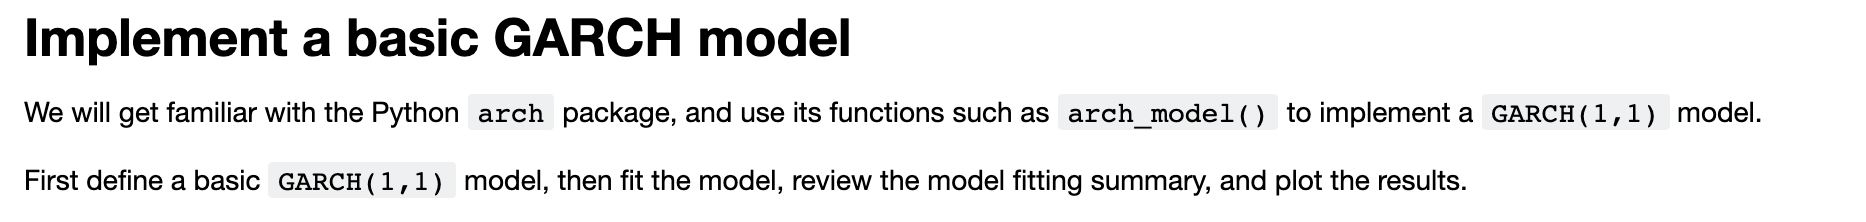

In [16]:
# Specify GARCH model assumptions
basic_gm = arch_model(sp_data['Return'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model
gm_result = basic_gm.fit(update_freq = 4)

Iteration:      4,   Func. Count:     24,   Neg. LLF: 1408.723892562239
Iteration:      8,   Func. Count:     45,   Neg. LLF: 1348.1703117257093
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1348.1674538138982
            Iterations: 11
            Function evaluations: 60
            Gradient evaluations: 11


In [17]:
# Display model fitting summary
print(gm_result.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                 Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1348.17
Distribution:                  Normal   AIC:                           2704.33
Method:            Maximum Likelihood   BIC:                           2719.97
                                        No. Observations:                  368
Date:                Mon, Jul 26 2021   Df Residuals:                      367
Time:                        00:37:44   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0222      0.404  5.493e-02      0.956 [ -0.770,  0.81

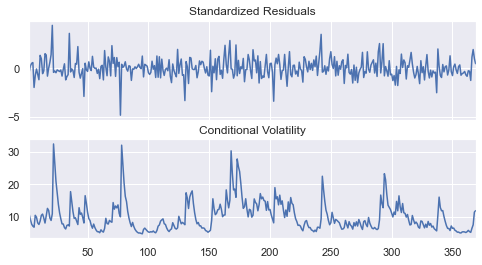

In [18]:
# Plot fitted results
gm_result.plot()
plt.show()

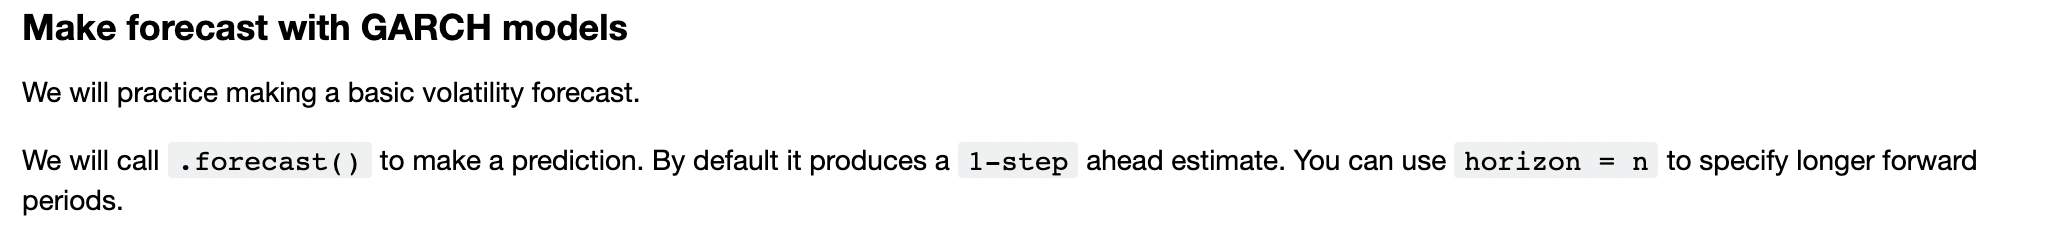

In [19]:
# Make 5-period ahead forecast
gm_forecast = gm_result.forecast(horizon = 5)

# Print the forecast variance
print(gm_forecast.variance[-1:])

            h.1         h.2         h.3         h.4         h.5
369  106.123891  114.982782  123.841674  132.700566  141.559458


h.1 in row '369' is a 1-step ahead forecast made using data up to and including that date